In [1]:
import sys
print(sys.executable)

/usr/bin/python3


In [3]:
# Initialiser Spark
spark = SparkSession.builder \
    .appName("Clustering with PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/18 20:55:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/18 20:55:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/18 20:55:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Import des bibliothèques

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

### Chargement des données 

In [4]:
# Charger les données nettoyées
catalogue = spark.read.csv("data/processed/catalogue_processed.csv", header=True, inferSchema=True)

### Prétraitement des données

In [5]:
# Afficher les premières lignes
print("Aperçu des données du catalogue :")
catalogue.show(5)

Aperçu des données du catalogue :
+--------+----------------+---------+-----------+--------+--------+-------+--------+-----+--------------+
|  marque|             nom|puissance|   longueur|nbPlaces|nbPortes|couleur|occasion| prix|longueur_index|
+--------+----------------+---------+-----------+--------+--------+-------+--------+-----+--------------+
| Renault|     Espace 2.0T|      165|     longue|       7|       5|   bleu|    true|21245|           1.0|
|   Honda|        FR-V 1.7|      125|     longue|       7|       5|   bleu|   false|19550|           1.0|
| Renault|Vel Satis 3.5 V6|      245|très longue|       5|       5|   bleu|    true|34440|           3.0|
|Mercedes|            A200|      136|    moyenne|       5|       5|   noir|    true|18130|           2.0|
|  Lancia| Ypsilon 1.4 16V|       90|     courte|       5|       3|   gris|   false|13500|           0.0|
+--------+----------------+---------+-----------+--------+--------+-------+--------+-----+--------------+
only showing

In [6]:
# Séparer les voitures neuves et d'occasion
catalogue_new = catalogue.filter(col("occasion") == False)

In [7]:
# Supprimer les doublons des voitures neuves en fonction du nom
catalogue_new = catalogue_new.dropDuplicates(["nom"])

In [9]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ["puissance", "longueur_index", "nbPlaces", "nbPortes", "prix"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
catalogue_new = assembler.transform(catalogue_new)

In [10]:
# Normalisation des données
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(catalogue_new)
catalogue_new = scaler_model.transform(catalogue_new)

### Clustering

In [11]:
# Clustering avec KMeans
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=123)
model = kmeans.fit(catalogue_new)
catalogue_new = model.transform(catalogue_new)

25/01/18 20:57:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [12]:
# Afficher les clusters
print("Résultats du clustering :")
catalogue_new.select("marque", "nom", "puissance", "prix", "prediction").show()

Résultats du clustering :
+----------+--------------+---------+-----+----------+
|    marque|           nom|puissance| prix|prediction|
+----------+--------------+---------+-----+----------+
|   Peugeot|      1007 1.4|       75|13750|         3|
|       BMW|          120i|      150|35800|         0|
|      Saab|      9.3 1.8T|      150|38600|         0|
|      Audi|        A2 1.4|       75|18310|         3|
|  Mercedes|          A200|      136|25900|         0|
|      Audi|    A3 2.0 FSI|      150|28500|         0|
|    Nissan|    Almera 1.8|      115|16450|         0|
|      Mini|Copper 1.6 16V|      115|18200|         3|
|      Fiat|     Croma 2.2|      147|24780|         0|
|  Daihatsu|     Cuore 1.0|       58| 8850|         1|
|   Renault|   Espace 2.0T|      165|30350|         0|
|     Honda|      FR-V 1.7|      125|19550|         0|
|Volkswagen|  Golf 2.0 FSI|      150|22900|         0|
|   Renault|   Laguna 2.0T|      170|27300|         0|
|     Dacia| Logan 1.6 MPI|       90| 7

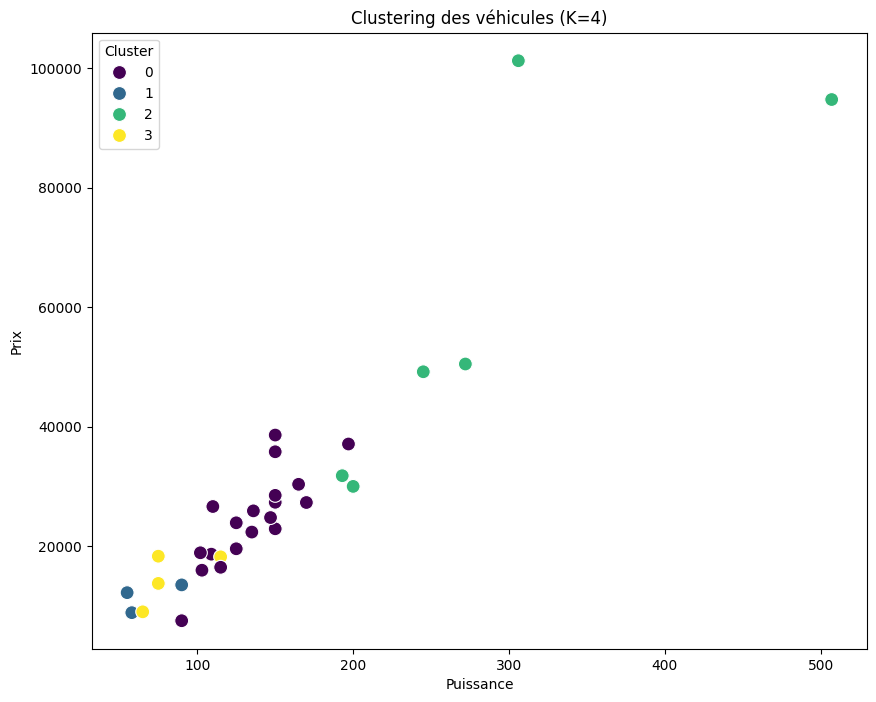

In [13]:
# Visualisation des clusters (nécessite la conversion en Pandas)
catalogue_new_pd = catalogue_new.select("puissance", "prix", "prediction").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(x="puissance", y="prix", hue="prediction", data=catalogue_new_pd, palette="viridis", s=100)
plt.title("Clustering des véhicules (K=4)")
plt.xlabel("Puissance")
plt.ylabel("Prix")
plt.legend(title="Cluster")
plt.show()

In [23]:
# Sélectionner uniquement les colonnes nécessaires pour la sauvegarde
columns_to_save = ["marque", "nom", "puissance", "longueur", "nbPlaces", "nbPortes", "prix", "prediction"]
catalogue_new_selected = catalogue_new.select(columns_to_save)

# Sauvegarder les données avec les clusters
catalogue_new_selected.write.csv("data/clustered/catalogue_clusters.csv", header=True, mode="overwrite")

#### Ajouter les clusters à immatriculations

In [15]:
# Charger les immatriculations nettoyées
immatriculations = spark.read.csv("data/processed/immatriculations_processed.csv", header=True, inferSchema=True)


In [16]:
# Fusionner les clusters du catalogue avec les immatriculations
catalogue_clusters = catalogue_new.select("marque", "nom", "prediction")
immatriculations_with_clusters = immatriculations.join(catalogue_clusters, on=["marque", "nom"], how="left")

In [17]:
# Filtrer les immatriculations pour ne garder que les voitures neuves
immatriculations_with_clusters = immatriculations_with_clusters.filter(col("occasion") == False)

In [19]:
# Sauvegarder les immatriculations avec les clusters
immatriculations_with_clusters.write.csv("data/clustered/immatriculations_clusters.csv", header=True, mode="overwrite")

In [21]:

# Afficher les premières lignes des immatriculations avec les clusters
print("Aperçu des immatriculations avec les clusters :")
immatriculations_with_clusters.show(5)

Aperçu des immatriculations avec les clusters :
+--------+--------------+---------------+---------+-----------+--------+--------+-------+--------+------+----------+
|  marque|           nom|immatriculation|puissance|   longueur|nbPlaces|nbPortes|couleur|occasion|  prix|prediction|
+--------+--------------+---------------+---------+-----------+--------+--------+-------+--------+------+----------+
|  Nissan| Maxima 3.0 V6|     8955 RA 70|      200|très longue|       5|       5|  rouge|   false| 30000|         2|
|   Dacia| Logan 1.6 MPI|     2095 ZI 23|       90|    moyenne|       5|       5|   gris|   false|  7500|         0|
| Renault|Megane 2.0 16V|     3916 OI 98|      135|    moyenne|       5|       5|   noir|   false| 22350|         0|
|Mercedes|          S500|     3454 UH 18|      306|très longue|       5|       5|   bleu|   false|101300|         2|
|  Jaguar| X-Type 2.5 V6|      504 CE 26|      197|     longue|       5|       5|   bleu|   false| 37100|         0|
+--------+------